In [6]:
import pandas

In [7]:
airline = pandas.read_csv('airline.csv', parse_dates=['Month']) #읽을 때 날짜로 읽어라 

In [8]:
airline.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [9]:
airline['Month'].dtype

dtype('<M8[ns]')

## 시각화

In [10]:
import seaborn

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


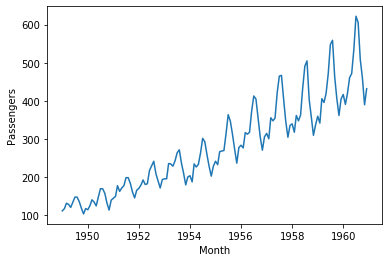

In [11]:
seaborn.lineplot('Month', 'Passengers', data=airline)
# 증가하는 트렌드, 계절성 (1년단위), 비정상 (증가하는 폭도 점점 커지고 있음 )

In [14]:
airline['Passengers'].rolling(window = 12).mean() #12달 평균

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
139    463.333333
140    467.083333
141    471.583333
142    473.916667
143    476.166667
Name: Passengers, Length: 144, dtype: float64

### 이동 평균을 빨간색으로 덧그린다 

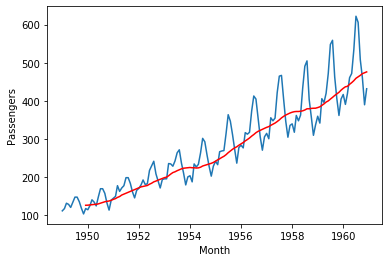

In [16]:
seaborn.lineplot('Month', 'Passengers', data=airline)
seaborn.lineplot(
    airline['Month'], 
    airline['Passengers'].rolling(window = 12).mean(), #rollung mean (이동 평균)
    color='red') 

비정상을 정상으로 바꿔보는 방법 

- 바뀌는 부분 (빼주기) - 빨간 추세 선
- 안 바뀌는 부분 → 정상 (일정하게 오르락 내리락하는 선)
- 그렇지만 만약 바뀌는 부분(선)을 빼도 다른 선이 큰 폭으로 오르락 내리락하게 된다면 비정상임

## ACF

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

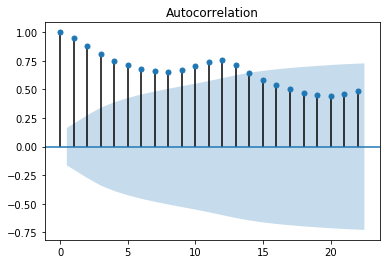

In [34]:
fig = plot_acf(airline['Passengers']) #24개월 acf(0개월은 자기자신이니까 1) - 비정상 패턴 

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

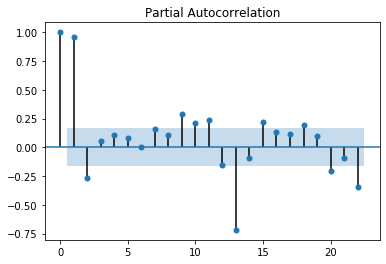

In [36]:
fig = plot_pacf(airline['Passengers'])

## 정상성 검정 Augmented Dickey-Fuller Test
- p< 0.05 정상

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
result = adfuller(airline['Passengers'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: 0.815368879206047
p-value: 0.991880243437641


## 로그 변환과 차분

In [24]:
import numpy

In [39]:
x = airline['Passengers'].values
x = numpy.log(x) #로그 변환

In [40]:
diff = x[1:] - x[:-1] #차분 

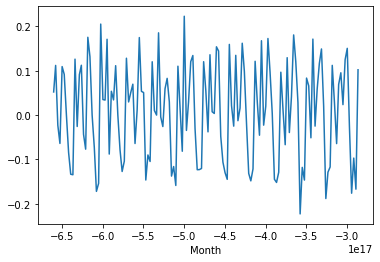

In [41]:
seaborn.lineplot(
    airline.iloc[1:, 0],
    diff)
    

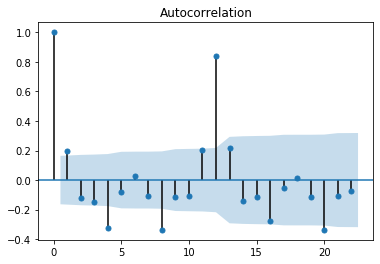

In [42]:
fig = plot_acf(diff)
# 계절성을 보이는 상관관계 -> 12달이 툭 튀어나와 있음 

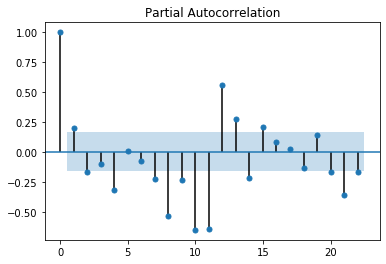

In [43]:
fig = plot_pacf(diff)

In [56]:
result = adfuller(diff)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -2.7171305983881595
p-value: 0.07112054815085424


## SARIMA

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# 예측할 때 쓰는 사리마스 
# 전통적인 시계열 분석의 끝판왕 같은 느낌 

### 데이터를 마지막 24개월어치를 테스트용으로 잘라둔다

In [60]:
x_train = airline.iloc[:-24, 1]
x_test = airline.iloc[-24:, 1]

In [61]:
res = SARIMAX(
    x_train, 
    order=(1, 1, 1), # pdq
    seasonal_order=(1, 1, 1, 1) # PDQm
    # order 3, seasonla_order 4 = 7개의 숫자만 정해주면 예측을 해줌 (예측이 젤 잘되는 숫자 찾기)
).fit()

In [47]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 1)   Log Likelihood                -550.921
Date:                           Wed, 09 Oct 2019   AIC                           1111.843
Time:                                   15:37:26   BIC                           1125.696
Sample:                                        0   HQIC                          1117.468
                                           - 120                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5085      0.042     12.090      0.000       0.426       0.591
ma.L1         -0.9998      3.583     -0.279      0.780      -8.022       6.022
ar.S.L1        0.5085      0.042     12.090      0.000       0.426       0.591
ma.S.L1       -0.9998      3.583     -0.279      0.780      -8.022       6.022
sigma2       599.3766   4286.739      0.140      0.889   -7802.477    9001.230
===================================================================================
Ljung-Box (Q):                      255.87   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               7.35   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.83e+23. Standard errors may be unstable.
"""

- 테스트용으로 잘라둔 24개월치를 예측

In [62]:
n = len(x_train)
m = len(x_test)
forecast = res.predict(n + 1, n+m)

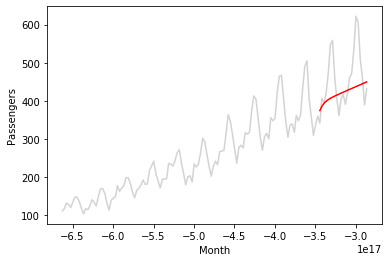

In [63]:
seaborn.lineplot('Month', 'Passengers', data=airline, color='lightgrey')
seaborn.lineplot(
    airline.iloc[-24:, 0],
    forecast,
    color='red'
)
# 회색선이 실제 추세, 마지막 24개월이 빨간선 (예측) -> 별로 안 맞음 -> pdqm을 잘못 골랐나봐 ^^ -> 다시 수치 바꿔서 넣어서 실제 패턴을 찾기 (목적)

In [64]:
from sklearn.metrics import mean_squared_error

In [65]:
mean_squared_error(x_test, forecast) #오차 제곱 평균 
# 오차를 제곱해서 평균을 냈을 때 수치가 작아야함 


5607.489079845414

In [83]:
res = SARIMAX(
    x_train, 
    order=(1, 1, 1), # pdq
    seasonal_order=(12, 0, 1, 3) # P 3개월 DQ m 계절의 길이 3 
).fit()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



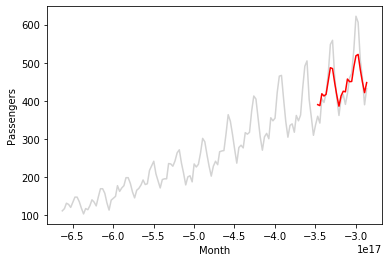

In [84]:
seaborn.lineplot('Month', 'Passengers', data=airline, color='lightgrey')
seaborn.lineplot(
    airline.iloc[-24:, 0],
    forecast,
    color='red'
)

In [85]:
from sklearn.metrics import mean_squared_error
# 그래프 말고 그냥 수치적으로 잘 맞는 지 보려면 mse 수치를 내면 됨. 

In [86]:
mean_squared_error(x_test, forecast) #오차 제곱 평균 
# 오차를 제곱해서 평균을 냈을 때 수치가 작아야함 
# 아까 5000이상이었는 데 지금 낮아짐

1629.2751677315973

## Facebook Prophet

### 설치

In [ ]:
# !conda install -y pystan

In [ ]:
# !pip install fbprophet plotly

### 예측

In [70]:
from fbprophet import Prophet

In [71]:
df = airline.iloc[:-24, :].copy()

- porphet은 컬럼 이름을 날짜는 ds, 숫자 부분은 y로 고정
- y het은 예측값 


In [72]:
df.columns = ['ds', 'y']

In [73]:
m = Prophet()
m.fit(df)
# 알림 : 주단위, 일단위 계절성은 없는 거 같아서 내가 꺼버렸어. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [74]:
future = pandas.DataFrame({'ds': airline['Month'].values})

In [75]:
pp = m.predict(future)

In [76]:
pp.head()
# trend : 추세 부분을 뺀 거 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,108.551413,65.269107,112.512354,108.551413,108.551413,-20.206478,-20.206478,-20.206478,-20.206478,-20.206478,-20.206478,0.0,0.0,0.0,88.344935
1,1949-02-01,110.721667,60.448459,103.999389,110.721667,110.721667,-27.744139,-27.744139,-27.744139,-27.744139,-27.744139,-27.744139,0.0,0.0,0.0,82.977528
2,1949-03-01,112.681897,93.163987,139.953358,112.681897,112.681897,4.779790,4.779790,4.779790,4.779790,4.779790,4.779790,0.0,0.0,0.0,117.461687
3,1949-04-01,114.852151,86.548775,132.787802,114.852151,114.852151,-4.864661,-4.864661,-4.864661,-4.864661,-4.864661,-4.864661,0.0,0.0,0.0,109.987490
4,1949-05-01,116.952397,87.786460,134.437783,116.952397,116.952397,-5.781821,-5.781821,-5.781821,-5.781821,-5.781821,-5.781821,0.0,0.0,0.0,111.170576


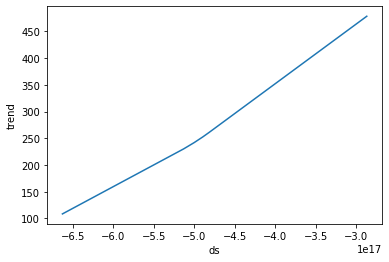

In [77]:
seaborn.lineplot('ds', 'trend', data=pp)
# 추세만 남기기 (미세하게 꺾이고 있음) -> 비정상 데이터도 알아서 처리해줌 

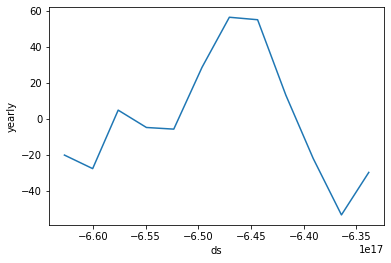

In [78]:
seaborn.lineplot('ds', 'yearly', data=pp.iloc[:12])
# ds , yearly -> 연단위 패턴 --> 계절성도 자동으로 찾아줌 
# 7,8월에 많이 비행기가 다니네 
# iloc :12 부분을 뺴면 연단위 패턴만 보여줌 (오르락 내리락) 매년 반복되는 거니까 그냥 12개월 치만 보면 됌 

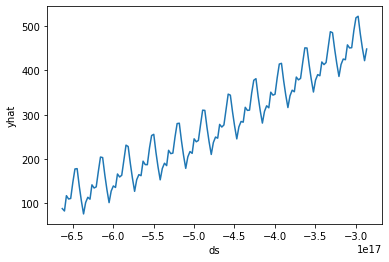

In [79]:
seaborn.lineplot('ds', 'yhat', data=pp)
# ds, yhay -> 전체 예측 

In [80]:
forecast = pp['yhat'].values[-24:]

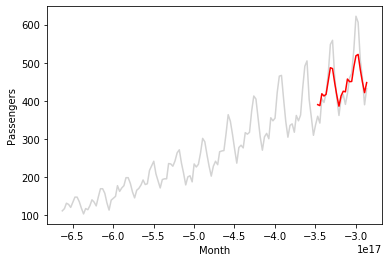

In [81]:
seaborn.lineplot('Month', 'Passengers', data=airline, color='lightgrey')
seaborn.lineplot(
    airline.iloc[-24:, 0],
    forecast,
    color='red'
)

In [82]:
mean_squared_error(x_test, forecast)
# 아까 5000 이상 나왔는 데 1600으로 줄어듬

1629.2751677315973

In [87]:
import numpy as np

# R 제곱

In [89]:
1 - mean_squared_error(x_test, forecast)/np.var(x_test)

0.7078417666882719

# 원래 분산의 70%를 설명해주고 있음 -> 좋은 모델 